## __Beta Variational AutoEncoder__

Beta Variational Autoencoder (beta-VAE) just has one adjustable hyper-parameter, $\beta$ added to original VAE framework. If we keep $β = 1$ in beta-VAE modelling, we get original VAE.

Source: [beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework](https://openreview.net/forum?id=Sy2fzU9gl)

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2

__MNIST__ dataset is of handwritten digits.

Here, ``test`` has $10,000$ images, and ``train`` has $60,000$ images each with $(28, 28, 1)$ shape

In [2]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [3]:
#Creating data loaders

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


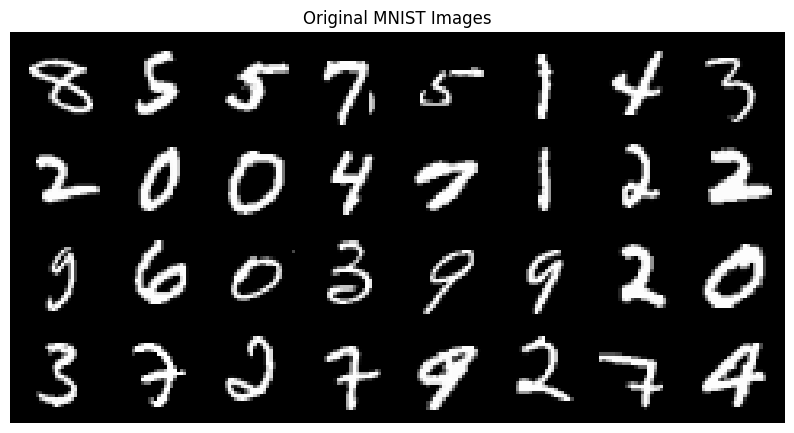

In [4]:
#visualizing some images

def show_images(images, title=None, nrow=8):

  grid = make_grid(images, nrow=nrow, padding=2, normalize=True)
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(grid, (1,2,0))) #changing order of grid to (H, W, C)
  if title:
    plt.title(title)
  plt.axis('off')
  plt.show()

#getting new batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

#plotting images
show_images(images[:32], "Original MNIST Images")

In [5]:
#latent dimension for we need to extract
latent_dim = 20

In [6]:
class Encoder(nn.Module):

  def __init__(self, latent_dim = 2):
    super(Encoder, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias =False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )
    self.fc_mean = nn.Linear(128 * 4 * 4, latent_dim)
    self.fc_log_variance = nn.Linear(128 * 4 * 4, latent_dim)

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    mean = self.fc_mean(x)
    log_variance = self.fc_log_variance(x)
    return mean, log_variance

In [7]:
from torchsummary import summary
print("Encoder Summary:\n")
summary(Encoder(), input_size=(1, 28, 28))

Encoder Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             288
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,432
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,728
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              ReLU-9            [-1, 128, 4, 4]               0
           Linear-10                    [-1, 2]           4,098
           Linear-11                    [-1, 2]           4,098
Total params: 101,092
Trainable params: 101,092
Non-trainable params: 0
----------------------------------------------------------------
Input size (

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)

        self.conv_trans_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1,output_padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        x = self.conv_trans_layers(x)
        return x

In [9]:
print("Decoder Summary:\n")
summary(Decoder(), input_size=(latent_dim, ))

Decoder Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]          43,008
   ConvTranspose2d-2             [-1, 64, 7, 7]          73,728
       BatchNorm2d-3             [-1, 64, 7, 7]             128
         LeakyReLU-4             [-1, 64, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 14, 14]          18,432
       BatchNorm2d-6           [-1, 32, 14, 14]              64
         LeakyReLU-7           [-1, 32, 14, 14]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]             288
           Sigmoid-9            [-1, 1, 28, 28]               0
Total params: 135,648
Trainable params: 135,648
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.52
Estimated Total Size (MB): 0.76
-------------------------

__Reparametrization trick__ has no changes in beta-vae, just as encoder-decoder written earlier.

In [10]:
#using same reparametrization trick of basic_vae
def reparameterize(mean, log_variance):
  std = torch.exp(log_variance/2)
  eps = torch.randn_like(std)
  return mean + eps*std

### __Beta-Varational AutoEncoder__

In [11]:
class BetaVAE(nn.Module):
  def __init__(self, latent_dim=2):
    super(BetaVAE, self).__init__()
    self.encoder = Encoder(latent_dim)
    self.decoder = Decoder(latent_dim)

  def forward(self, x):
    mean, log_variance = self.encoder(x)
    z = reparameterize(mean, log_variance)
    x_reconstructed = self.decoder(z)
    return x_reconstructed, mean, log_variance

### Loss Function

VAE loss has two components

__Reconstruction Loss__ given by cross entropy loss, and __KL-Divergence__.

Here, a $\beta$ variable is introduced. A $\beta$ value encourages more distanglement or stronger constraint on KL-Divergene Loss, If added as $\beta < 1$, then we get our loss function more focussed on reconstruction loss.



In [12]:
def beta_vae_loss(x_reconstructed, x, mean, log_variance, beta=4.0):
    """
    Computes the beta-VAE loss function.
    Beta: Controls the relative importance of the reconstruction loss vs the KL divergence.
    Rest of the parameters are as same, as in basic vae.
    """
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction="sum")

    # KL Divergence (scaled by beta)
    kld_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    total_loss = recon_loss + beta * kld_loss  # Beta scales the KL term

    return recon_loss, kld_loss, total_loss

#### Training

In [13]:
learning_rate = 25e-4
num_epochs = 30
beta = 3.0  

model = BetaVAE(latent_dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total Loss should be equal to Reconstruction loss added with beta term multiplied with Kl divergence loss i.e.,

$\text{Total Loss} = \beta \cdot \text{KL-Loss}$

In [15]:
#training loop
import time
start = time.perf_counter()

def train(epoch):
    model.train()
    train_recon_loss = 0
    train_kld_loss = 0
    train_total_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mean, log_var = model(data)
        recon_loss, kld_loss, total_loss = beta_vae_loss(recon_batch, data, mean, log_var, beta)

        total_loss.backward()
        train_recon_loss += recon_loss.item()
        train_kld_loss += kld_loss.item()
        train_total_loss += total_loss.item()
        optimizer.step()

    print(f'Epoch {epoch}: Total Loss: {train_total_loss /len(train_loader.dataset):.2f} '
          f'Reconstruction (BCE) Loss: {train_recon_loss / len(train_loader.dataset):.2f} '
          f'KL Loss: {train_kld_loss / len(train_loader.dataset):.2f}')

for epoch in range(1, num_epochs + 1):
    train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

Epoch 1: Total Loss: 178.27 Reconstruction (BCE) Loss: 146.77 KL Loss: 10.50
Epoch 2: Total Loss: 145.01 Reconstruction (BCE) Loss: 108.31 KL Loss: 12.23
Epoch 3: Total Loss: 141.86 Reconstruction (BCE) Loss: 104.71 KL Loss: 12.38
Epoch 4: Total Loss: 140.15 Reconstruction (BCE) Loss: 103.00 KL Loss: 12.38
Epoch 5: Total Loss: 138.93 Reconstruction (BCE) Loss: 101.78 KL Loss: 12.38
Epoch 6: Total Loss: 138.07 Reconstruction (BCE) Loss: 100.93 KL Loss: 12.38
Epoch 7: Total Loss: 137.18 Reconstruction (BCE) Loss: 100.12 KL Loss: 12.35
Epoch 8: Total Loss: 136.52 Reconstruction (BCE) Loss: 99.46 KL Loss: 12.35
Epoch 9: Total Loss: 136.11 Reconstruction (BCE) Loss: 99.03 KL Loss: 12.36
Epoch 10: Total Loss: 135.65 Reconstruction (BCE) Loss: 98.56 KL Loss: 12.36
Epoch 11: Total Loss: 135.32 Reconstruction (BCE) Loss: 98.19 KL Loss: 12.37
Epoch 12: Total Loss: 135.01 Reconstruction (BCE) Loss: 97.82 KL Loss: 12.40
Epoch 13: Total Loss: 134.60 Reconstruction (BCE) Loss: 97.38 KL Loss: 12.41
E

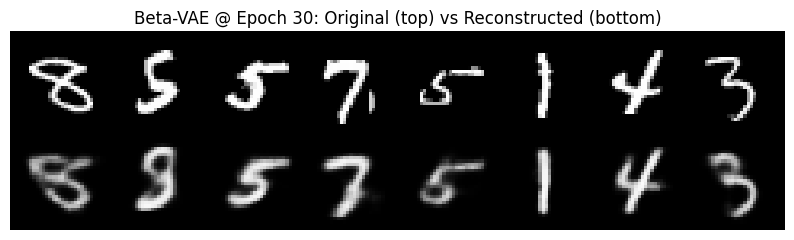

<Figure size 640x480 with 0 Axes>

In [ ]:
# reconstructing some images after last epoch
model.eval()
with torch.no_grad():
  sample = images[:8]
  recon, _, _ = model(sample)

  comparison = torch.cat([sample, recon])
  show_images(comparison, f'Beta-VAE @ Epoch {epoch}: Original (top) vs Reconstructed (bottom)')
  plt.savefig('img/beta_vae.png')

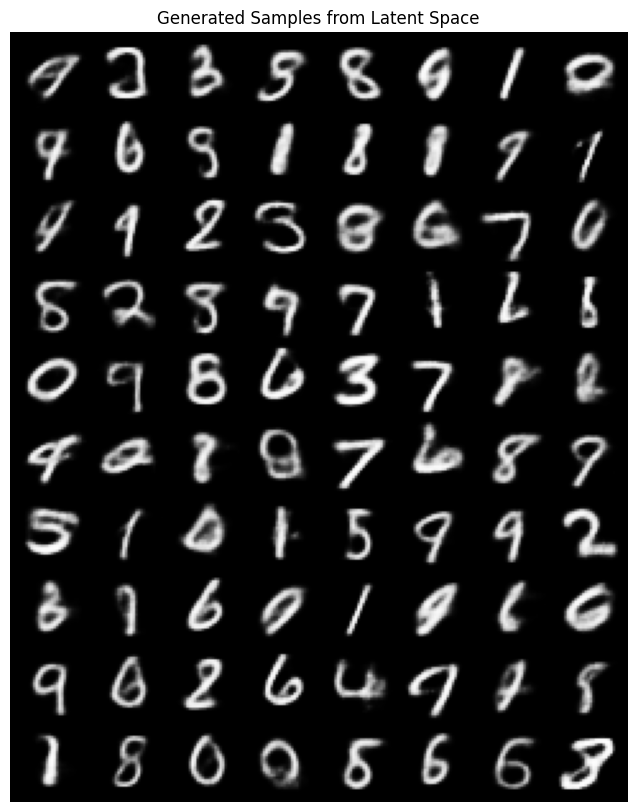

In [17]:
#generating samples from latent space
def generate_samples(model, n=80, nrow=10):
    model.eval()
    with torch.no_grad():
        # Getting the latent dimension from the model's encoder
        latent_dim = model.encoder.fc_mean.out_features
        z = torch.randn(n, latent_dim)
        samples = model.decoder(z)
        show_images(samples, "Generated Samples from Latent Space")

generate_samples(model)

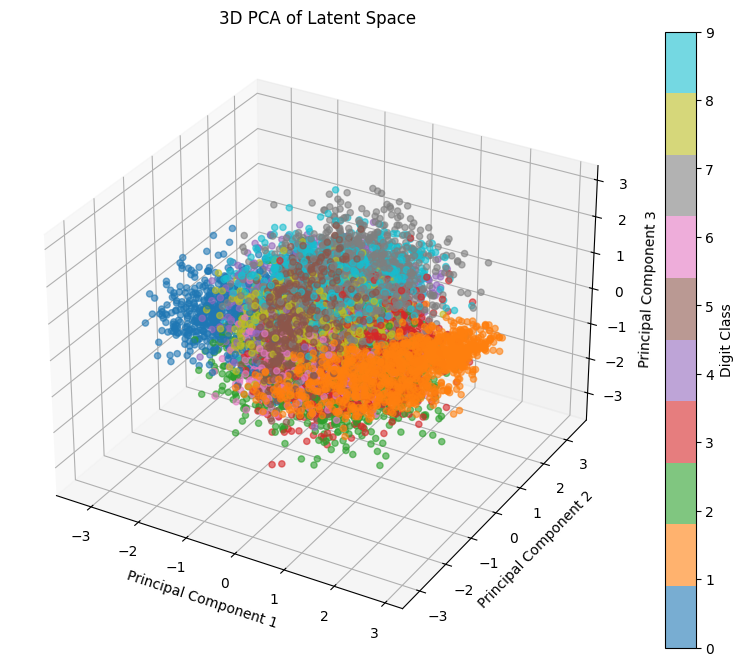

In [18]:
from sklearn.decomposition import PCA

def plot_latent_space_pca(model, data_loader, n_components=3):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            mean, _ = model.encoder(data)
            latents.append(mean)
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    # Performing PCA to reduce dimensionality to n_components
    pca = PCA(n_components=n_components)
    latents_reduced = pca.fit_transform(latents)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1],
                         latents_reduced[:, 2], c=labels, cmap='tab10', alpha=0.6)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of Latent Space')
    fig.colorbar(scatter, ticks=range(10), label='Digit Class')

    plt.show()

plot_latent_space_pca(model, test_loader, n_components=3)

- Beta Variational Autoencoder (Using same ``Latent Dimension`` of $20$ from ``basic_vae``)

| Exp No. | Epochs | Learning Rate | __Beta__ $\beta$ | Total Loss | Reconstruction Loss | KL-D Loss |
| ----- | ----- | ----- | -----| -----| -----| -----|
| 1 | 30 | 25e-4 | 8.0 | 172.95 | 132.52 | 5.05 |
| 2 | 30 | 25e-4 | 6.0 | 160.44 | 118.76 | 6.95 |
| 3 | 30 | 25e-4 | 5.0 |  152.58 | 111.47 | 8.22 |
| 4 | 30 | 25e-4 | 4.0 | 143.04 | 102.96 | 10.02 |
| __5__ | __30__ | __25e-4__ | __3.0__ | __131.89__ | __94.46__ | __12.48__ |  
| 6 | 30 | 25e-4 | 2.0 | 117.59 | 84.57 | 16.51 |
